In [393]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tsfresh import extract_features
import sklearn
import seaborn as sns
from sklearn.metrics import confusion_matrix
from math import floor

In [394]:
#Codigo implementado a mano
def Parse_Data(f1):
    custom_fc_parameters = {
        
            'absolute_maximum': None,

    }

    
    tf = None
    size = 18000    
    increment = 1200
    features = len(custom_fc_parameters)
    numpy_matrix_result = np.zeros(shape = (features, len(f1['x']), int(size/increment)))

    for index, j in enumerate(np.arange(0,size,increment)):
        temp_x = []
        for i in range(len(f1['x'])):
            temp_x.append(f1['x'][i][0][j:j+increment])
        
        #Pasar la data a Pandas
        all_data = []
        for i, ts in enumerate(temp_x):
            data = [[x, i] for x in ts]
            all_data.extend(data)  # Collect all data in a list
        df = pd.DataFrame(all_data, columns=['value', 'id'])

        #Sacar la información de la data
        df.columns = ['value', 'id']
        tf = extract_features(df, column_id='id', column_value='value', default_fc_parameters=custom_fc_parameters)
        for i, k in enumerate(tf.keys()):
            numpy_matrix_result[i][:,index] = tf[k].to_numpy()

    #Reducción de dimension ordenamiento de data con respecto a t
    X = numpy_matrix_result[0]
    for i in range(len(tf.keys())-1):
        X = np.concatenate((X, numpy_matrix_result[i+1]), axis=1)
    X = X[:,~np.any(np.isnan(X), axis=0)]
    X = X[:,~np.all(X == 0, axis=0)]

    return X

In [395]:
#Codigo de Lab anterior "Soft SVM Hackaton"

def h(X,w,b):
  return np.dot(X,w.T) + b
def loss(y,y_aprox,C,w):
  return ((1/2)*(np.linalg.norm(w)) + C*np.sum(np.fmax(0,1-y*y_aprox)))/len(y)
def derivatives(x, y,y_aprox, w, C):
  dw = np.zeros(len(w))
  db = 0
  for i in range(len(y)):
    if (y[i]*y_aprox[i]) < 1:
      dw -= y[i]*(x[i])
      db -= y[i]
  dw *= C
  dw += w
  db *= C
  return db,dw
def Update(w, b, db, dw, alpha):
  w = w - alpha*dw
  b = b - alpha*db
  return w, b
def training(X, Y, C, alpha, epochs):
  w = np.array([np.random.rand() for i in range(X.shape[1])])
  b = np.random.rand()
  error = []
  for i in range(epochs):
    Y_aprox = h(X,w,b)
    db, dw = derivatives(X, Y,Y_aprox, w, C)
    w, b = Update(w, b, db, dw, alpha)
    L = loss(Y,Y_aprox,C,w)
    if (i % 10000 == 0):
      print(L)
  return w, b, error
def testing(X,W,b):
  # write your code here
  rpta = h(X,W,b)
  y_pred = []
  for n in rpta:
    if n < 0:
      y_pred.append(0)
    else:
      y_pred.append(1)
  return y_pred

In [396]:
file_name = "train.h5"
f1 = h5py.File(file_name, 'r+')
X = Parse_Data(f1)
print(X.shape)

Feature Extraction: 100%|██████████| 41/41 [00:02<00:00, 17.74it/s]

(204, 15)


In [397]:
temp_y = []
for i in range(len(f1['y'])):
    if (f1['y'][i] == 0):
        temp_y.append(-1)
    else:
        temp_y.append(1)
Y = np.array(temp_y)
print(X.shape)
X_train, X_test, Y_train, Y_test = sklearn.model_selection.train_test_split(X, Y, test_size=0.33, random_state=42)
w, b, big_L = training(X, Y, 0.1, 3e-6, 40000)
print(X.shape)

(204, 15)
0.23569786533124518
0.1816525549566781
0.137209745892763
0.10726506368884337
(204, 15)


[1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0]
Alcoholicos Identificados: 0.47058823529411764
No Alcoholicos Identificados: 0.9215686274509803
0.7151144054141154


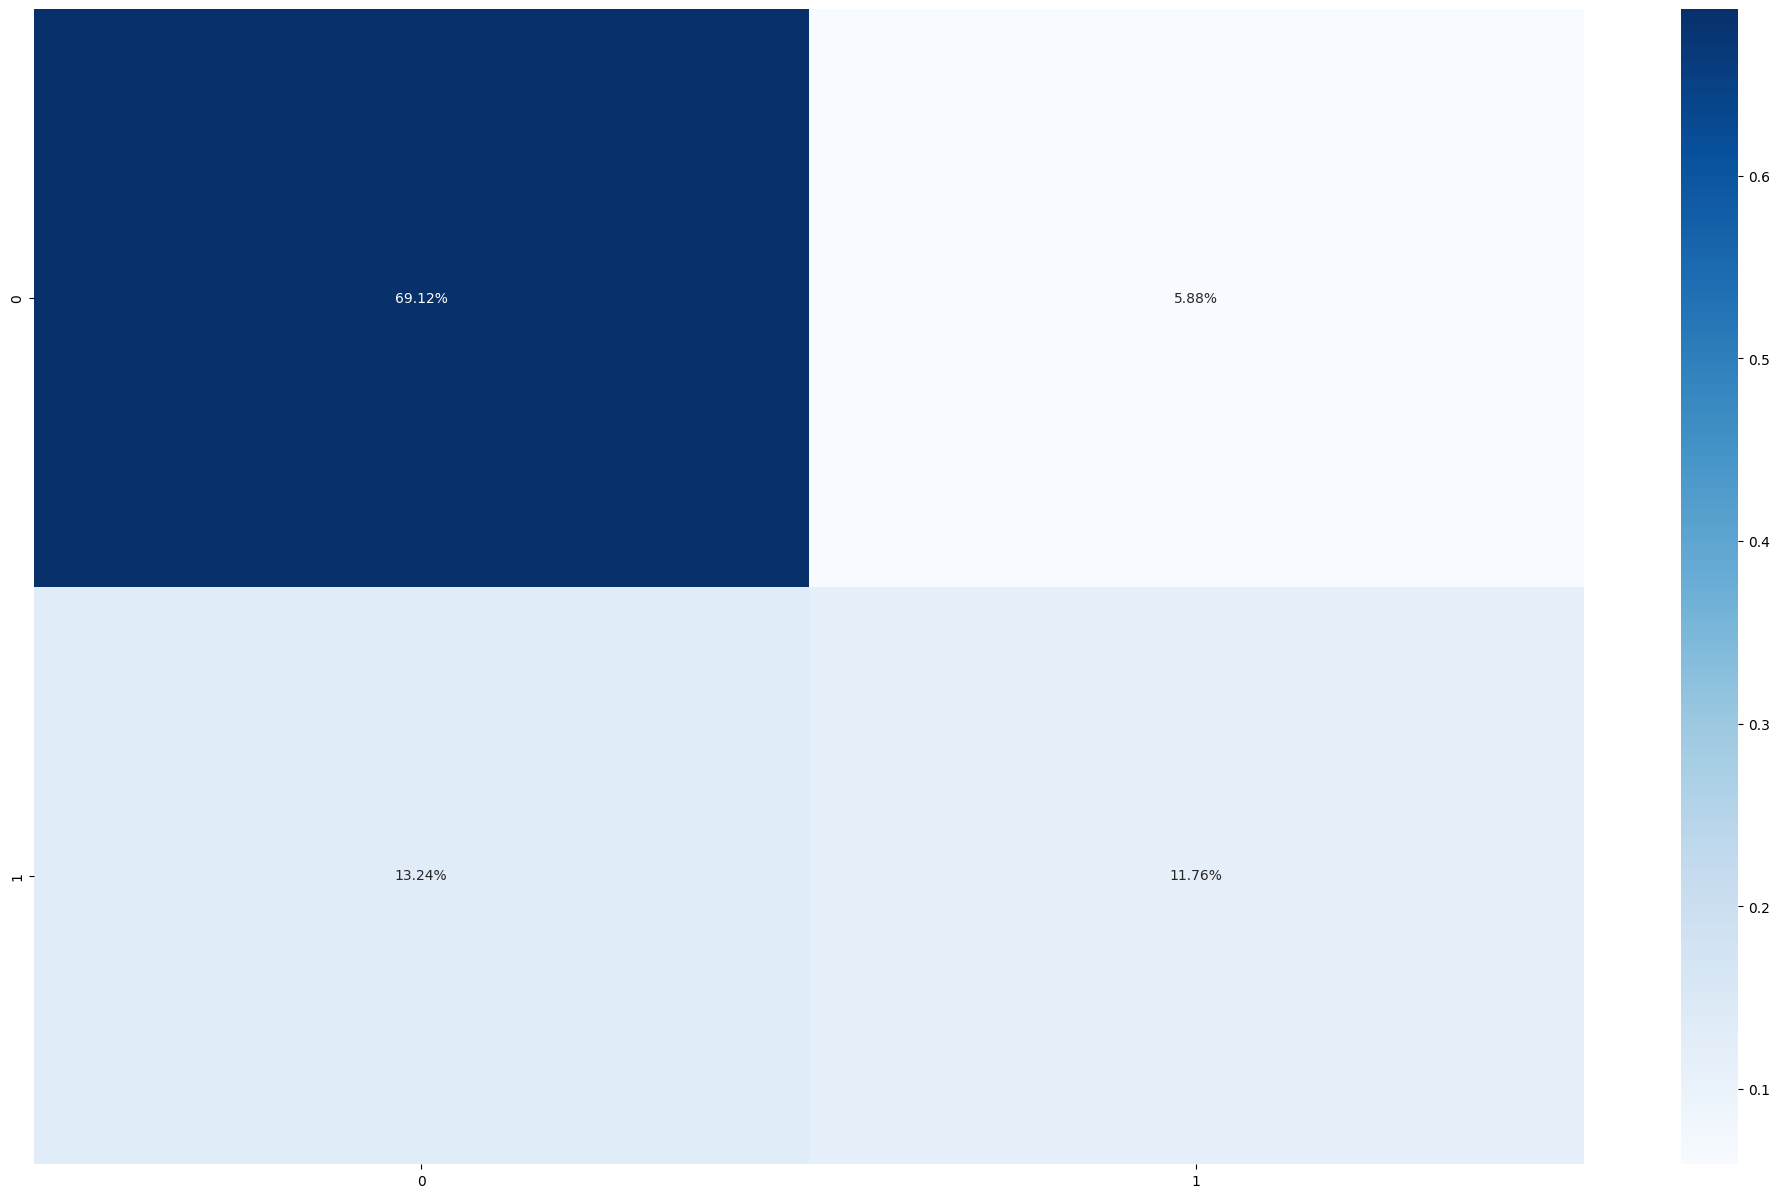

In [398]:
y_true = []
for n in Y_test:
    if n < 0:
        y_true.append(0)
    else:
        y_true.append(1)
Y_test = y_true

y_pred = testing(X_test, w, b)
cf_matrix = confusion_matrix(Y_test, y_pred)
plt.figure(figsize=(25, 15))
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, fmt='.2%', cmap='Blues')

print(y_pred)
print(Y_test)

unos_aggarados = 0
unos_totales = 0
for i in range(len(y_pred)):
    if (Y_test[i] == 1):
        unos_totales += 1
        if (Y_test[i] == y_pred[i]):
            unos_aggarados += 1 

zeros_agarrados = 0
zeros_totales = 0
for i in range(len(y_pred)):
    if (Y_test[i] == 0):
        zeros_totales += 1
        if (Y_test[i] == y_pred[i]):
            zeros_agarrados += 1 
print("Alcoholicos Identificados: " + str(unos_aggarados/unos_totales))
print("No Alcoholicos Identificados: " + str(zeros_agarrados/zeros_totales))
print(sklearn.metrics.f1_score(Y_test, y_pred, average='macro'))

In [399]:
file_name = "test.h5"
file_test = h5py.File(file_name, 'r+')
final_x_test = Parse_Data(file_test)


Feature Extraction: 100%|██████████| 41/41 [00:02<00:00, 16.43it/s]


In [400]:
y_pred = testing(final_x_test, w, b)
print(y_pred)

[1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1]


In [401]:
id = range(1, len(y_pred) + 1)

In [402]:

final_df = pd.DataFrame(
    {   'ID': id,
        'result': y_pred,
    })


In [403]:
print(final_df)
final_df.to_csv('results.csv', index=False)



      ID  result
0      1       1
1      2       0
2      3       0
3      4       0
4      5       0
..   ...     ...
200  201       0
201  202       0
202  203       0
203  204       1
204  205       1

[205 rows x 2 columns]
